The dataset contains information about 7 different types of fish that are sold at the fish market. It is necessary to build a model that predicts the weight of the fish according to its parameters.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge


from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
random_state = 10

# Read the data

In [3]:
data = pd.read_csv("Fish.csv")
display(data.head(3))
display(data.describe(include="all"))

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961


,Species,Weight,Length1,Length2,Length3,Height,Width
count,159,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
unique,7,NaN,NaN,NaN,NaN,NaN,NaN
top,Perch,NaN,NaN,NaN,NaN,NaN,NaN
freq,56,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,NaN,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,NaN,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,NaN,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,NaN,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,NaN,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500


- **Species**: type of fish
- **Weight**: fish weight in grams
- **Length1**: fish length
- **Length2**: diagonal fish length
- **Length3**: transverse length
- **Height**: height
- **Width**: diagonal width

Among the data there is a record where the zero weight of the fish is indicated. Obviously this is a data error.

In [4]:
data[data["Weight"] == 0]

,Species,Weight,Length1,Length2,Length3,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


Drop the bad data

In [5]:
data = data[data["Weight"] > 0]

# EDA

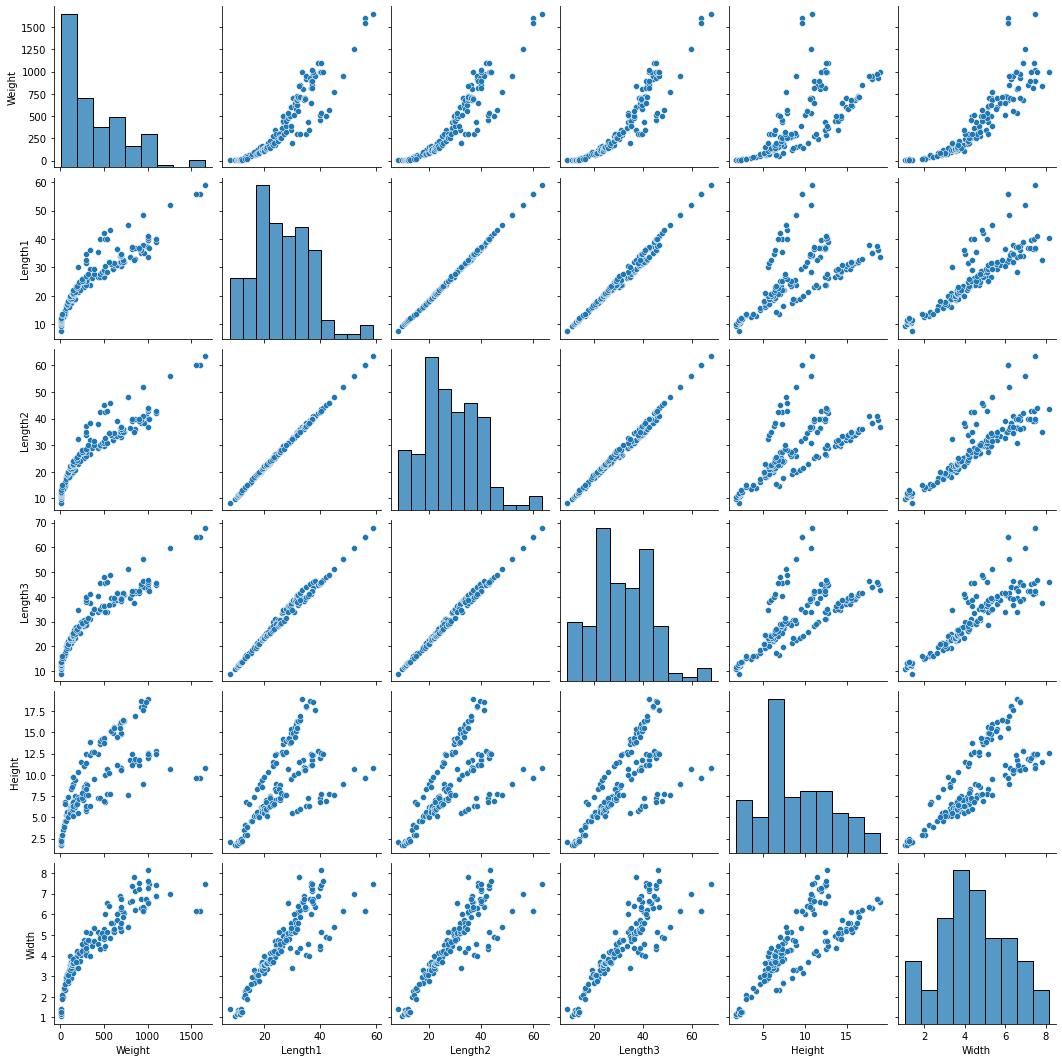

In [6]:
ax = sns.pairplot(data)

### Conclusion #1
1. There is a non-linear relationship between all predictors and the dependent variable Weight.

2. The length parameters (Length1-2-3) have a correlation close to 1.

----
Because there is a non-linear relationship between the dependent variable and all predictors, let's try to transform the dependent variable. The logarithm did not bring the desired result, so let's try to apply the Box-Cox transformation (the task is not to explain the dependence, only to predict)


In [7]:
fitted_data, fitted_lambda = stats.boxcox(data["Weight"]) 
data["Weight"] = fitted_data

At the same time, we exclude predictors with a high correlation

In [8]:
data = data[["Length1", "Height", "Width", "Species", "Weight"]]

Let's take a look at the pairplot one more time

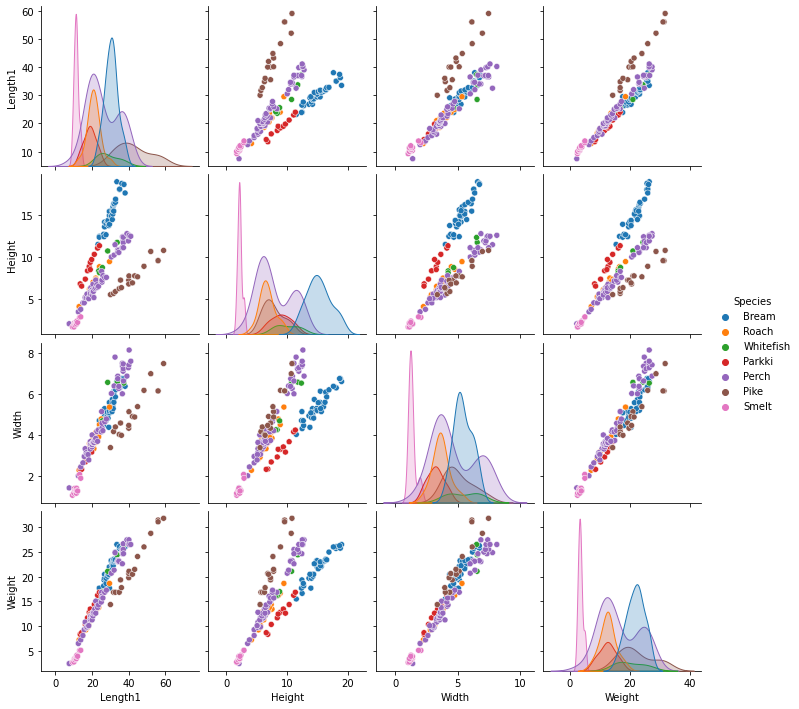

In [9]:
ax = sns.pairplot(data, hue="Species")

### Conclusion #2

Data looks mutch better!
There is a linear relatinships between weights and other predictors.

So, now we have done two conditions for applying linear regression:
 - linear relationships
 - no multicollineariry

# Let's make dataset

In [10]:
y = data["Weight"]
X = data[["Length1", "Height", "Width", "Species"]]
X = pd.get_dummies(X, columns=["Species"])

# Regression analysis

In [11]:
model_ols = sm.OLS(y, X)
fitted = model_ols.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2301.
Date:                Fri, 07 Oct 2022   Prob (F-statistic):          3.10e-154
Time:                        07:40:26   Log-Likelihood:                -142.34
No. Observations:                 158   AIC:                             304.7
Df Residuals:                     148   BIC:                             335.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Length1               0.4198      0.02

Make sure the error distribution is normal.

The Jarque Bera value is >6, so the error is not normally distributed.

The error is not normally distributed. Statistic: 0.946, p-value: 9.527e-06


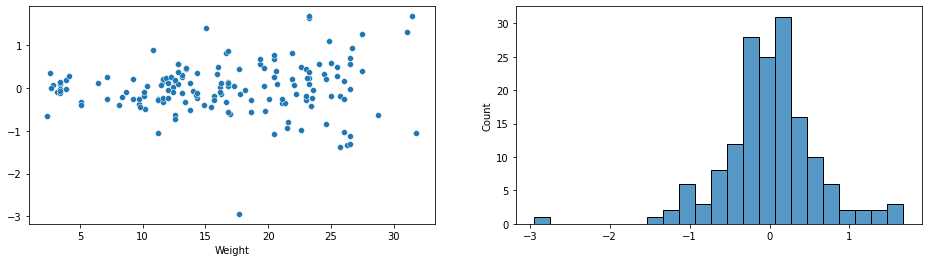

In [12]:
fig, ax = plt.subplots(figsize=(16,4), ncols=2)
ax[0] = sns.scatterplot(x=y, y=fitted.resid, ax=ax[0])
ax[1] = sns.histplot(fitted.resid, ax=ax[1])

statistic, p_value = shapiro(fitted.resid)
if p_value>0.05:
    print("The error is normally distributed. Statistic: {0:.3}, p-value: {1:.4}".format(statistic, p_value))
else:
    print("The error is not normally distributed. Statistic: {0:.3}, p-value: {1:.4}".format(statistic, p_value))

### Conclusion #3
The error normality requirement is not met. We cannot use statistical tests to determine the significance of predictors.

Heteroscedasticity is observed.

Let's try to do something with it.

## Outliers

To remove outliers, we use the Cook's distance - we exclude all points that have the greatest influence.

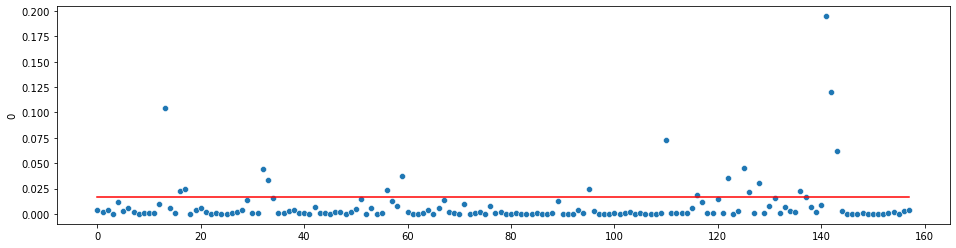

In [17]:
influence = fitted.get_influence()
(c, p) = influence.cooks_distance
distances = pd.DataFrame(c, index=X.index)

dsc = distances.describe()
# За выбросы будем считать те точки, которые отклонябтся от среднего значения более чем в 2 раза.
cutoff = dsc.loc["mean"].values[0]*2

fig, ax = plt.subplots(figsize=(16, 4))
cut_off_df = np.full(distances.shape[0], cutoff )
x_ = range(distances.shape[0])
ax = sns.scatterplot(y=distances[0], x=x_, ax=ax)
ax = sns.lineplot(y=cut_off_df, x=x_, ax=ax, color="red")

In [14]:
idx = distances[distances[0] < cutoff].index

X_cleared = X.loc[idx, :]
y_cleared = y.loc[idx]

In [15]:
model_ols_cleared = sm.OLS(y_cleared, X_cleared)
fitted_cleared = model_ols_cleared.fit()
print(fitted_cleared.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4534.
Date:                Fri, 07 Oct 2022   Prob (F-statistic):          9.23e-157
Time:                        07:42:32   Log-Likelihood:                -61.472
No. Observations:                 139   AIC:                             142.9
Df Residuals:                     129   BIC:                             172.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Length1               0.3938      0.02

The error is normally distributed. Statistic: 0.99, p-value: 0.4666


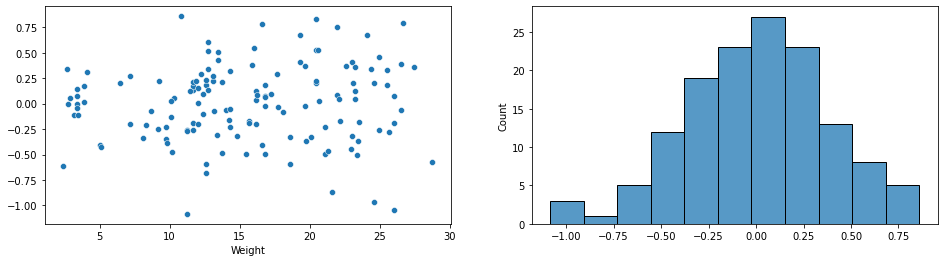

In [19]:
fig, ax = plt.subplots(figsize=(16,4), ncols=2)
ax[0] = sns.scatterplot(x=y_cleared, y=fitted_cleared.resid, ax=ax[0])
ax[1] = sns.histplot(fitted_cleared.resid, ax=ax[1])

statistic, p_value = shapiro(fitted_cleared.resid)
if p_value>0.05:
    print("The error is normally distributed. Statistic: {0:.3}, p-value: {1:.4}".format(statistic, p_value))
else:
    print("The error is not normally distributed. Statistic: {0:.3}, p-value: {1:.4}".format(statistic, p_value))

### Coclusion #4
1. After removing the outliers, the model errors have a normal distribution. The requirement for the normality of errors is satisfied.
2. There is no heteroscedasticity. The homoscedasticity requirement is satisfied.
3. All predictors in the model are significant (P>|t| < 0.05)
4. The resulting model explains 99.7% of the variability in the dependent variable

# Linear regression train

In [20]:
model_linear = LinearRegression()
score = cross_val_score(model_linear, X_cleared, y_cleared, cv=3, n_jobs=-1, scoring='r2')

print("R^2 statistic: {0:.3}".format(score.mean()))

R^2 statistic: 0.986


### Выводы
In the course of solving the problem, the following was done:
- correlated signs are excluded
- eliminated non-linearity of the relationship
- outliers were removed, which led to the normalization of errors and data homoscedasticity

The cross-validation model explains 98.6% of the variance in the dependent variable.

In [ ]:
#model_linear.fit(X_cleared, y_cleared)
#scores = model_linear.coef_
#fig, ax = plt.subplots(figsize=(10,3))
#ax = sns.barplot(x=scores, y=X_cleared.columns, ax=ax) 